#  ***k-NN and Decision Tree on Wisconsin Cancer Dataset***
## *Class*: COSC528 - Project 3
### *Author*: Ian R. Stewart
### *Due Date*: November 6, 2018

In [277]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
savePath = '/Users/i6o/Research/COSC 528/Project 3/Figures/'

## 1) Data Exploration

In [278]:
# Reading data
features = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
df = pd.read_csv('breast-cancer-wisconsin.data',names=features)
'''
------------------------------------------
     Details for DataFrame Features
------------------------------------------
1. Sample code number: id number 
2. Clump Thickness: 1 – 10
3. Uniformity of Cell Size: 1 – 10 
4. Uniformity of Cell Shape: 1 – 10 
5. Marginal Adhesion: 1 – 10
6. Single Epithelial Cell Size: 1 – 10 
7. Bare Nuclei: 1 – 10
8. Bland Chromatin: 1 – 10
9. Normal Nucleoli: 1 – 10
10. Mitoses: 1 – 10
11. Class: (2 for benign, 4 for malignant)
'''
df.head(1)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2


In [279]:
print df.shape
df.dtypes

(699, 11)


Sample code number              int64
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [280]:
# Dropping rows with '?' values in Bare Nuclei feature.
df['Bare Nuclei'] = df['Bare Nuclei'].astype(str)
count=0;indexes=[]
for i in df['Bare Nuclei']:
    try:
        j = float(i)
    except:
        indexes.append(count)
    count+=1
print len(indexes)
df = df.drop(indexes)
df['Bare Nuclei'] = df['Bare Nuclei'].astype(int)
df.dtypes

16


Sample code number             int64
Clump Thickness                int64
Uniformity of Cell Size        int64
Uniformity of Cell Shape       int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

In [281]:
#sns.pairplot(df[features[1::]],hue='Class',palette='coolwarm')
#plt.savefig(savePath+'full_pairplot.png',dpi=600)

Creating function to split data into training and test sets.

In [282]:
def test_split(data_x,data_y,n):
    '''
    Description: Splits <data> variable into four random 
        parts based on <n> percentage of data for training 
        set.
    
    :param data_x {array} : x data to split,train,predict
    :param data_y {array} : y data to split,train,predict
    :param n      {float} : percentage of data to split
    
    :returns {6}: (x_train,x_test,y_train,y_test) ;     
        x_train = training set for <x> parameter
        x_test  = test set for <x> parameter
        y_train = training set for <y> paramter
        y_test  = test set for <y> parameter
        i_train = indexes of training set split
        i_test  = indexes of test set split
    
    e.g. x_tr,x,y_tr,y,i_tr,i_test=test_split(data,data_to_predict,40)
    '''
    data_x = np.asarray(data_x)
    length_test = int(round(len(data_x)*(n/100.)))
    # Create random integers between two numbers with no repeats
    train_list = random.sample(range(0,len(data_x)), length_test)
    train_list.sort()
    test_list = np.arange(0,len(data_x))
    test_list = np.delete(test_list,train_list)
    data_y = np.array(data_y)
    x_train,y_train = np.array(data_x[train_list]),np.array(data_y[train_list])
    x_test,y_test   = np.array(data_x[test_list]),np.array(data_y[test_list])
    
    return (x_train,x_test,y_train,y_test,train_list,list(test_list))

Not using *Sample Code No.* in analysis. Using the *Class* feature as the predictor parameter and the other features (minus the *Sample Code No.*) as the estimating parameters. Also, *z*-standardizing data

In [283]:
df_standardized = (df-df.mean())/df.std()
data_x = df_standardized.iloc[:,1:-2]
data_y = df.iloc[:,-1]
print data_x.shape,data_y.shape

(683, 8) (683,)


In [284]:
x_train,x_test,y_train,y_test,train_list,test_check = test_split(data_x,data_y,60)

In [285]:
# Checking split shapes
print 'Training set shapes: \n\t{ Data:%s,\tPredictor:%s }'%(x_train.shape,y_train.shape)
print 'Test set shapes: \n\t{ Data:%s,\tPredictor:%s }'%(x_test.shape,y_test.shape)

Training set shapes: 
	{ Data:(410, 8),	Predictor:(410,) }
Test set shapes: 
	{ Data:(273, 8),	Predictor:(273,) }


## **2.0) Data Analysis**: *k*-**NN**

In [286]:
def test_split(data_x,data_y,n):
    data_x = np.asarray(data_x)
    length_test = int(round(len(data_x)*(n/100.)))
    # Create random integers between two numbers with no repeats
    train_list = random.sample(range(0,len(data_x)), length_test)
    train_list.sort()
    test_list = np.arange(0,len(data_x))
    test_list = np.delete(test_list,train_list)
    data_y = np.array(data_y)
    x_train,y_train = np.array(data_x[train_list]),np.array(data_y[train_list])
    x_test,y_test   = np.array(data_x[test_list]),np.array(data_y[test_list])
    
    return (x_train,x_test,y_train,y_test,train_list,list(test_list))

In [287]:
x_train,x_test,y_train,y_test,train_list,test_list = test_split(data_x,data_y,50)

In [288]:
from collections import Counter

def getNeighbors(x_training,x_test,y_training,y_test,k=3):
    y_prediction = {}; dist = []
    counter = 0; y_pred = []
    for i in x_test:
        dist = []
        for j in x_training:
            dist.append(sum(np.absolute(i-j)))
        dist_sorted = np.array(sorted(dist))

        closest_indexes = []
        for value in range(k):
            index = np.where(dist==dist_sorted[value])[0][0]
            closest_indexes.append(index)
            
        classes = np.array(y_training)[closest_indexes]
        class_chosen = Counter(classes)
        predicted_class = class_chosen.keys()[np.argmax(class_chosen.values())]
        y_prediction[counter] = predicted_class
        y_pred.append(predicted_class)
        counter+=1
        
    return y_prediction,y_pred

def confusion_matrix(y_predicted,y_true,prints=True):
    TN=0;FN=0;TP=0;FP=0
    for i in range(len(y_predicted)):
        y_pred0 = y_predicted[i]
        y_true0 = y_true[i]
        if y_pred0 == y_true0:
            if y_pred0==4:
                TP+=1
            else:
                TN+=1
        else:
            if y_pred0 == 2:
                FN+=1
            if y_pred0 == 4:
                FP+=1
    if prints:
        print '======== CONFUSION MATRIX ========'
        print '\t\tPREDICTED CLASS\n\t\t---------------\nTRUE CLASS  |  Benign\tMalignant\n  Benign    |\t%i\t%i\n  Malignant |\t%i\t%i'%(TN,FP,FN,TP)
        print '=================================='
    return TN,FN,TP,FP
            
def getMetrics(TN,FN,TP,FP,prints=True):
    TN,FN,TP,FP=float(TN),float(FN),float(TP),float(FP)
    Acc = (TN+TP)/(TN+TP+FN+FP)
    TPR = TP/(TP+FN)
    PPV = TP/(TP+FP)
    TNR = TN/(TN+FP)
    F1  = (2*PPV*TPR)/(PPV+TPR)
    if prints:
        metrics = [Acc,TPR,PPV,TNR,F1]
        labels = ['Acc.','TPR','PPV','TNR','F1']
        print '====== Performance Metrics ======'
        for i in range(len(labels)):
            print '\t%s\t: %.4f'%(labels[i],metrics[i])
        print '================================='
    return Acc,TPR,PPV,TNR,F1

In [289]:
y_dict,y_pred = getNeighbors(x_train,x_test,y_train,y_test)

In [290]:
TN,FN,TP,FP = confusion_matrix(y_pred,y_test)

======== CONFUSION MATRIX ========
		PREDICTED CLASS
		---------------
TRUE CLASS  |  Benign	Malignant
  Benign    |	220	7
  Malignant |	2	112


In [291]:
metrics= getMetrics(TN,FN,TP,FP)

====== Performance Metrics ======
	Acc.	: 0.9736
	TPR	: 0.9825
	PPV	: 0.9412
	TNR	: 0.9692
	F1	: 0.9614


#### Testing Scikit-Learns KNN

In [292]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [293]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
pred = knn.predict(x_test)
print confusion_matrix(y_test,pred)
print '\n'
print classification_report(y_test,pred)

[[218   9]
 [  2 112]]


             precision    recall  f1-score   support

          2       0.99      0.96      0.98       227
          4       0.93      0.98      0.95       114

avg / total       0.97      0.97      0.97       341



Text(0.5,0,u'k (No. of Neighbors)')

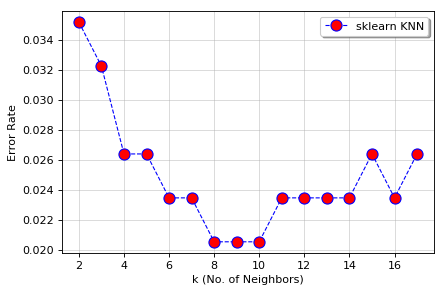

In [300]:
error_rate = []
for i in range(2,18):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i!=y_test))
plt.figure(dpi=80)
plt.plot(range(2,18),error_rate,'bo--',linewidth=1,markerfacecolor='red',markersize=10,label='sklearn KNN')
plt.grid(alpha=0.5)
plt.legend(loc='upper right',fancybox=True,shadow=True)
plt.ylabel('Error Rate');plt.xlabel('k (No. of Neighbors)')
#plt.savefig(savePath+'kNN_Elbow_ErrorRate.png',dpi=600)

In [27]:
def test_split(data_x,data_y,n):
    data_x = np.asarray(data_x)
    length_test = int(round(len(data_x)*(n/100.)))
    # Create random integers between two numbers with no repeats
    train_list = random.sample(range(0,len(data_x)), length_test)
    train_list.sort()
    test_list = np.arange(0,len(data_x))
    test_list = np.delete(test_list,train_list)
    data_y = np.array(data_y)
    x_train,y_train = np.array(data_x[train_list]),np.array(data_y[train_list])
    x_test,y_test   = np.array(data_x[test_list]),np.array(data_y[test_list])
    
    return (x_train,x_test,y_train,y_test,train_list,list(test_list))

In [28]:
x_train,x_test,y_train,y_test,train_list,test_list = test_split(data_x,data_y,50)

In [301]:
from collections import Counter

def getNeighbors(x_training,x_test,y_training,y_test,k=3):
    y_prediction = {}; dist = []
    counter = 0; y_pred = []
    for i in x_test:
        dist = []
        for j in x_training:
            dist.append(sum(np.absolute(i-j)))
        dist_sorted = np.array(sorted(dist))

        closest_indexes = []
        for value in range(k):
            index = np.where(dist==dist_sorted[value])[0][0]
            closest_indexes.append(index)
            
        classes = np.array(y_training)[closest_indexes]
        class_chosen = Counter(classes)
        predicted_class = class_chosen.keys()[np.argmax(class_chosen.values())]
        y_prediction[counter] = predicted_class
        y_pred.append(predicted_class)
        counter+=1
        
    return y_prediction,y_pred

def confusion_matrix(y_predicted,y_true,prints=True):
    TN=0;FN=0;TP=0;FP=0
    for i in range(len(y_predicted)):
        y_pred0 = y_predicted[i]
        y_true0 = y_true[i]
        if y_pred0 == y_true0:
            if y_pred0==4:
                TP+=1
            else:
                TN+=1
        else:
            if y_pred0 == 2:
                FN+=1
            if y_pred0 == 4:
                FP+=1
    if prints:
        print '======== CONFUSION MATRIX ========'
        print '\t\tPREDICTED CLASS\n\t\t---------------\nTRUE CLASS  |  Benign\tMalignant\n  Benign    |\t%i\t%i\n  Malignant |\t%i\t%i'%(TN,FP,FN,TP)
        print '=================================='
    return TN,FN,TP,FP
            
def getMetrics(TN,FN,TP,FP,prints=True):
    TN,FN,TP,FP=float(TN),float(FN),float(TP),float(FP)
    Acc = (TN+TP)/(TN+TP+FN+FP)
    TPR = TP/(TP+FN)
    PPV = TP/(TP+FP)
    TNR = TN/(TN+FP)
    F1  = (2*PPV*TPR)/(PPV+TPR)
    if prints:
        labels = ['Acc.','TPR','PPV','TNR','F1']
        print '====== Performance Metrics ======'
        for i in range(len(labels)):
            print '\t%s\t: %.4f'%(labels[i],metrics[i])
        print '================================='
    return Acc,TPR,PPV,TNR,F1

##### Choosing *k*=3 for optimal nearest-neighbors

In [302]:
y_dict,y_pred = getNeighbors(x_train,x_test,y_train,y_test,k=8)

In [303]:
TN,FN,TP,FP = confusion_matrix(y_pred,y_test)

======== CONFUSION MATRIX ========
		PREDICTED CLASS
		---------------
TRUE CLASS  |  Benign	Malignant
  Benign    |	221	6
  Malignant |	2	112


In [305]:
metrics= getMetrics(TN,FN,TP,FP)

====== Performance Metrics ======
	Acc.	: 0.9765
	TPR	: 0.9825
	PPV	: 0.9492
	TNR	: 0.9736
	F1	: 0.9655


## **2.1) Data Analysis - Decision Tree Analysis**

In [240]:
class decision_tree(object):
    
    def __init__(self,depth=2):
        self.max_depth = depth
    
    def gini(self,features,classes):
        gini_index = 0
        for feature in features:
            size=len(feature) ; score = 0.0
            for class_val in classes:
                score += ((feature[:,-1] == class_val).sum()/float(size))**2
            gini_index += (1.0-score)*(float(size)/sum([len(feature) for feature in features]))
        return gini_index
    
    def gini_score(self, groups, classes):
        n_samples = sum([len(group) for group in groups])
        gini = 0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            #print(size)
            for class_val in classes:
                #print(group.shape)
                p = (group[:,-1] == class_val).sum() / size
                #print(p)
                score += p * p
            gini += (1.0 - score) * (size / n_samples)
            #print(gini)
        return gini
    
    def entropy(self,data_y):
        elements,counts = np.unique(data_y,return_counts=True)
        en = []
        for i in range(len(elements)):
            en.append( (-counts[i]/sum(counts))*float(np.log2(counts[i]/sum(counts))) )
        return np.sum(en)
    
    def tree_split(self, feature, value, data):
        data_left = np.array([]).reshape(0,self.data.shape[1])
        data_right = np.array([]).reshape(0,self.data.shape[1])
        for i in data:
            if i[feature] <= value:
                data_left = np.vstack((data_left,i))
            if i[feature] > value:
                data_right = np.vstack((data_right,i))
        return data_left, data_right

    def choose_split(self, data):
        classes = np.unique(self.data[:,-1])
        best_feat = 999;best_val = 999;best_score = 999;best_groups = None
        for feat in range(self.data.shape[1]-1):
            for i in data:
                features = self.tree_split(feat,i[feat],self.data)
                if self.cost_function=='gini':
                    value = self.gini_score(np.array(features), classes)
                if self.cost_function=='entropy':
                    value = self.entropy(self.data_y)
                if value < best_score:
                    best_feat = feat
                    best_val = i[feat]
                    best_score = value
                    best_groups = groups
        output = {}
        output['feat'] = best_feat
        output['val'] = best_val
        output['groups'] = best_groups
        return output
    
    def split_attribute(self,leaf,depth):
        left_leaf, right_leaf = leaf['groups']; del(leaf['groups'])
        if depth >= self.max_depth:
            leaf['left'] = self.terminal_leaf(left_leaf)
            leaf['right'] = self.terminal_leaf(right_leaf)
            return
            
    def predict_sample(self, node, sample):
        if sample[node['feat']] < node['val']:
            if isinstance(node['left'],dict):
                return self.predict_sample(node['left'],sample)
            else:
                return node['left']
        else:
            if isinstance(node['right'],dict):
                return self.predict_sample(node['right'],sample)
            else:
                return node['right']
    
    def predict(self, X_test):
        self.prediction = np.array([])
        for i in X_test:
            self.prediction = np.append(self.prediction,self.predict_sample(self.root,i))
        return self.prediction
    ''''''
    def best_split(self, Xy):
        classes = np.unique(Xy[:,-1])
        best_score = 999
        for feat in range(Xy.shape[1]-1):
            for i in Xy:
                groups = self.tree_split(feat, i[feat], Xy)
                gini = self.gini_score(groups, classes)
                if gini < best_score:
                    best_feat = feat
                    best_val = i[feat]
                    best_score = gini
                    best_groups = groups
        output = {}
        output['feat'] = best_feat
        output['val'] = best_val
        output['groups'] = best_groups
        return output
    
    def terminal_node(self, group):
        # errored out: couldn't np.unique(nothing) or something - doesn't happen all the time
        #print(group[:,-1])
        classes, counts = np.unique(group[:,-1],return_counts=True)
        return classes[np.argmax(counts)]
            
    def split_branch(self, node, depth):
        left_node, right_node = node['groups']
        del(node['groups'])
        if not isinstance(left_node,np.ndarray) or not isinstance(right_node,np.ndarray):
            node['left'] = node['right'] = self.terminal_node(left_node + right_node)
            return
        if depth >= self.max_depth:
            node['left'] = self.terminal_node(left_node)
            node['right'] = self.terminal_node(right_node)
            return
    
    def build_tree(self):
        '''Recursively build tree, unclear if this is the correct way
        
        '''
        
        self.root = self.best_split(self.data)
        #print(self.root)
        self.split_branch(self.root, 1) # i don't understand how this is working, pointed to node?
        #print(self.root)
        return self.root
    
    def train(self,data_x,data_y,cost):
        self.cost_function = cost # entropy, gin, or misclassification error
        self.data_x = data_x      # numeric values for feature data
        self.data_y = data_y      # class values for feature data
        self.data = np.column_stack((data_x,data_y)) # creating matrix for training set
        self.build_tree()
        

In [241]:
dt = decision_tree()
dt.train(data_x=X_train,data_y=y_train,cost='gini')

In [259]:
class decision_tree(object):
    def __init__(self, max_depth,min_num_sample):
        self.max_depth = max_depth
        self.min_num_sample = min_num_sample
    
    
    def gini(self, groups, classes):
        n_samples = sum([len(group) for group in groups])
        gini = 0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                score += np.power((group[:,-1] == class_val).sum() / size,2)
            gini += (1.0-score)*(size/sum([len(group) for group in groups]))
        return gini
    
    def tree_split(self, feat, val, data):
        Xi_left = np.array([]).reshape(0,self.data.shape[1])
        Xi_right = np.array([]).reshape(0,self.data.shape[1])
        for i in self.data:
            if i[feat] <= val:
                Xi_left = np.vstack((Xi_left,i))
            if i[feat] > val:
                Xi_right = np.vstack((Xi_right,i))
        return Xi_left, Xi_right
    
    def best_split(self, data):
        classes = np.unique(self.data[:,-1])
        best_score = 999
        for feat in range(self.data.shape[1]-1):
            for i in self.data:
                groups = self.tree_split(feat, i[feat], self.data)
                gini = self.gini(groups, classes)
                if gini < best_score:
                    best_feat = feat
                    best_val = i[feat]
                    best_score = gini
                    best_groups = groups
        output = {}
        output['feat'] = best_feat
        output['val'] = best_val
        output['groups'] = best_groups
        return output
    
    def terminal_node(self, group):
        classes, counts = np.unique(group[:,-1],return_counts=True)
        return classes[np.argmax(counts)]
            
    def split_branch(self, node, depth):
        left_node, right_node = node['groups']
        del(node['groups'])
        if not isinstance(left_node,np.ndarray) or not isinstance(right_node,np.ndarray):
            node['left'] = node['right'] = self.terminal_node(left_node + right_node)
            return
        if depth >= self.max_depth:
            node['left'] = self.terminal_node(left_node)
            node['right'] = self.terminal_node(right_node)
            return
        if len(left_node) <= self.min_num_sample:
            node['left'] = self.terminal_node(left_node)
        else:
            node['left'] = self.best_split(left_node)
            self.split_branch(node['left'], depth+1)
        if len(right_node) <= self.min_num_sample:
            node['right'] = self.terminal_node(right_node)
        else:
            node['right'] = self.best_split(right_node)
            self.split_branch(node['right'], depth+1)
    
    def build_tree(self):
        self.root = self.best_split(self.data)
        self.split_branch(self.root, 1)
        return self.root
    
    def train(self,data_x,data_y):
        self.data_x = data_x
        self.data_y = data_y
        self.data = np.column_stack((data_x,data_y))
        self.root = self.best_split(self.data)
        self.split_branch(self.root, 1)
        
    def predict(self, X_test):
        self.y_pred = np.array([])
        for i in X_test:
            self.y_pred = np.append(self.y_pred,self.predict_sample(self.root,i))
        return self.y_pred
    
    def predict_sample(self, node, sample):
        if sample[node['feat']] < node['val']:
            if isinstance(node['left'],dict):
                return self.predict_sample(node['left'],sample)
            else:
                return node['left']
        else:
            if isinstance(node['right'],dict):
                return self.predict_sample(node['right'],sample)
            else:
                return node['right']


In [262]:
dt = decision_tree(max_depth=2,min_num_sample=20)
dt.train(X_train,y_train)
my_pred = dt.predict(X_test)

In [263]:
dt.root
my_pred

array([4., 2., 4., 4., 4., 4., 4., 2., 4., 2., 4., 2., 4., 2., 4., 2., 2.,
       4., 2., 2., 4., 2., 2., 4., 4., 4., 4., 2., 4., 4., 2., 2., 2., 4.,
       4., 2., 4., 2., 2., 2., 4., 2., 4., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 4., 4., 4., 4., 4., 2., 4., 2., 2., 2., 2., 4., 2., 2., 2.,
       4., 4., 4., 4., 2., 2., 2., 2., 4., 4., 4., 2., 2., 4., 2., 2., 4.,
       2., 4., 2., 4., 2., 4., 2., 4., 2., 4., 2., 4., 4., 4., 4., 2., 2.,
       4., 4., 2., 4., 2., 2., 2., 2., 2., 4., 2., 2., 2., 4., 2., 4., 4.,
       2., 4., 2., 2., 2., 4., 4., 2., 2., 2., 2., 2., 4., 4., 2., 2., 2.,
       2., 2., 4., 2., 4., 2., 2., 4., 2., 2., 2., 2., 4., 2., 2., 2., 4.,
       4., 2., 2., 4., 4., 4., 2., 2., 2., 4., 2., 4., 4., 2., 4., 2., 4.,
       2.])